In [1]:
# basic packages
import pandas as pd
import os
import warnings
import pyarrow as pa
import pyarrow.parquet as pq

#import geopandas as gpd
#import matplotlib

warnings.filterwarnings("ignore")

#Shared/Utility scripts
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from model_scripts import Simple_Eval, dataloader, dataprocessor,dataprocessor2, xgb_model, SSWEET #had to pip install xgboost
#HOME = os.path.expanduser('~')
HOME = os.getcwd()
# HOME = os.chdir('..')
# HOME = os.getcwd()

modelname = 'XGBoost'
model_path = f"{HOME}/SWEMLv2.0/Model/{modelname}"
if not os.path.exists(model_path):
    os.makedirs(model_path, exist_ok=True)
print(f"{modelname} development script, {device}")

dataprocessor /uufs/chpc.utah.edu/common/home/civil-group1/Johnson/SWEMLv2.0/AWSaccessKeys.csv
Device: cpu
dataprocessor /uufs/chpc.utah.edu/common/home/civil-group1/Johnson/SWEMLv2.0/AWSaccessKeys.csv
Device: cpu
Device: cpu


XGBoost development script, cpu


In [ ]:
date_basin = {'2015-04-06': 'Conejos',# - only one obs, likely poor Never seen prediction location
          '2015-04-07': 'Upper Rio Grande',
           '2018-03-30': 'Taylor',
          '2018-03-31': 'East',
          '2013-04-03': 'Tuolumne',
              '2013-04-29': 'Tuolumne'
             }

date_region = {'2015-04-06': 'Rocky Mountains',# - only one obs, likely poor Never seen prediction location
          '2015-04-07': 'Rocky Mountains',
           '2018-03-30': 'Rocky Mountains',
          '2018-03-31': 'Rocky Mountains',
          '2013-04-03': 'Sierra Nevada Mountains',
               '2013-04-29': 'Sierra Nevada Mountains'
              }

PDF = pd.DataFrame()
VDF = pd.DataFrame()
SWEDF = pd.DataFrame()

In [10]:
#load data
regionlist = ['SouthernRockies', 'Southwest', 'Northwest']
output_res = '750M_Resolution' #300M_Resolution, 500M_Resolution, #1000M_Resolution
DataFrame = 'Sturm_Seasonality_PrecipVIIRSGeoObsDFs'
fSCA_thresh = '20_fSCA_Thresh'
remove0swe = True #set to False to use all data, set to True to remove values under a certain threshold
removeswe_thresh = 1 #value in cm to remove ASO obs/rows from. 

alldata = dataloader.get_ML_Data(regionlist, output_res, DataFrame, fSCA_thresh)

#small adjustments to correct some data
#aspect
alldata['Aspect_Deg'] = alldata['Aspect_Deg']-270
df = alldata[alldata['Aspect_Deg']>= 0]
df['Aspect_Deg'] = abs(df['Aspect_Deg']-90)+270
alldata.update(df)
alldata['Aspect_Deg'] = abs(alldata['Aspect_Deg'])

#Precip - looks like its in inches
alldata['season_precip_cm'] = alldata['season_precip_cm']*2.54

'''for Vegetation_Sturm_Seasonality_PrecipVIIRSGeoObsDFs, ASO obs
put SW 2018-04-22, 2018-03-04, San Joaquin, in bad data folder seems too big for peaks
in Southern Rockies 2019-04-07, East River, way too high of values, put in bad data folder'''

Concatenating 14 for the model dataframe development.


  0%|          | 0/14 [00:00<?, ?it/s]

There are 48514 datapoints for model training/testing in the SouthernRockies modeling domain.
Concatenating 99 for the model dataframe development.


  0%|          | 0/99 [00:00<?, ?it/s]

There are 358940 datapoints for model training/testing in the Southwest modeling domain.
Concatenating 2 for the model dataframe development.


  0%|          | 0/2 [00:00<?, ?it/s]

There are 27214 datapoints for model training/testing in the Northwest modeling domain.
There are 434668 datapoints for model training/testing in the overall modeling domain.


'for Vegetation_Sturm_Seasonality_PrecipVIIRSGeoObsDFs, ASO obs\nput SW 2018-04-22, 2018-03-04, San Joaquin, in bad data folder seems too big for peaks\nin Southern Rockies 2019-04-07, East River, way too high of values, put in bad data folder'

In [ ]:
# Pulling out 3-29-2019 in Southwest
#date = '2019-03-29' # Merced
#date = '2019-04-19' # Blue
#dates = '2019-04-08' # Taylor
#One prediction in each watershed
dates = [#'2016-02-08', #Olympia
         '2015-04-06', #Conejos - only one obs, likely poor Never seen prediction location
       #  '2013-04-03', # Tuolomne
       #   '2016-03-29', #Olympic
       #   '2015-04-07', #upper Rio Grande
 #         '2013-04-29', #Tuolumne
       #   #'2015-06-02', #Upper Rio Grande
       #  # '2013-05-03', #Tuolumne
       #   #'2016-04-03', #Upper Rio Grande
       #   #'2013-05-25',#Tuolumne
       #   #'2016-04-04', #East
        #  '2013-06-01', #Tuolumne
 #         '2018-03-30', #Taylor
          #'2018-03-31', #East
       #   #'2018-05-24',#East
       #  #'2019-04-08', #Taylor
       # #  '2019-04-19', #Blue - only one obs?. two?, likely poor Never seen prediction location
       #   #'2019-06-09', #Taylor
       #   #'2019-06-10', #East
       #  # '2014-04-29', #Merced
       #  #'2019-03-29', # Merced
       #    '2015-04-12', #Kings
       #    '2019-03-25' #San Joaquin
    #'2019-03-24' Tuolumne high performance
         ]

DataUsed = [False, True] #use all data for training (True) and test with HOO, or have training/testing and HOO (False)
SampleMethods =  [False, True] #Randomly sample all data before splitting for train/test (TRue), split train/test first, then randomize training (False)
Res = ['300M_Resolution', '500M_Resolution', '750M_Resolution', '1000M_Resolution']
#train each model and predict
for output_res in Res:
    for date in dates:
        for dataused in DataUsed:
            for standard in SampleMethods:

                print(f"Training model to make predictions for {date_basin[date]} on {date} using: {output_res}, DataUsed = {dataused}, and SampleMethods = {standard}")

                TestArea = alldata[alldata['Date'] == date]
                TestArea.reset_index(inplace=True, drop=True)

                #remove Test area data from training/testing dataset
                df = pd.concat([alldata, TestArea]).drop_duplicates(keep=False)

                #clean the data
                df = dataprocessor.data_clean(df, regionlist)
                df.head()

                #temporary for seasonality relationship
                df.fillna(1, inplace = True)

                #convert dates to datetime format
                df.Date = pd.to_datetime(df.Date)

                input_columns = [
                            'cen_lat',	
                            'cen_lon',	
                            'Elevation_m',	
                            'Slope_Deg',	
                            'Aspect_Deg',	
                            'ns_1',	
                            'ns_2',	
                            'ns_3',	
                            'ns_4',	
                            'ns_5',	
                           # 'ns_6',	
                            #'VIIRS_SCA', 
                            'hasSnow',
                            'season_precip_cm',
                            'region_class',
                            'DOS', 
                            'WY_week',
                            'ns_1_week_mean', 
                            'ns_2_week_mean', 
                            'ns_3_week_mean', 
                            'ns_4_week_mean',
                            'ns_5_week_mean', 
                           # 'ns_6_week_mean', 
                            'Seasonal_ns_1_rel',
                            'Seasonal_ns_2_rel',
                            'Seasonal_ns_3_rel', 
                            'Seasonal_ns_4_rel',
                            'Seasonal_ns_5_rel', 
                          #  'Seasonal_ns_6_rel',
                            'sturm_value',
                        # 'vegetation_value'
                ]



                years = False
                splitratio = 0.1
                test_years = [2019]
                target = 'swe_cm'
                remove0swe = True #set to False to use all data, set to True to remove values under a certain threshold
                removeswe_thresh = 1 #value in cm to remove ASO obs/rows from. 
                #remove the large amounts of zero values

                df = dataloader.remove0swe(df, remove0swe, removeswe_thresh)

                  #fit a scaler,save, and scale the training data
                x_train, y_train, x_test, y_test = dataprocessor2.xgb_processor(
                                                                    regionlist,
                                                                    df, 
                                                                    years, 
                                                                    splitratio,
                                                                    test_years, 
                                                                    target, 
                                                                    input_columns, 
                                                                    model_path, 
                                                                    scalertype = 'MinMax',
                                                                    standard = standard,
                                                                    alldata = dataused #setting this to true will use all available data to train the model, uses HOO to test, There will not be any plots
                                                                    )

                #Train model
                tries = 1 #what is tries?
                hyperparameters = {
                    'max_depth': [6,7,8],     #[8], #range (7, 9,1), #7-good
                    'n_estimators':  [10,25,1000, 3500],#[3500], #range(3000, 3600, 500),  #5500 - at max tested estimator, test higher and lower values on HOO data
                    'eta': [0.01, 0.05, 0.1]
                }

                perc_data = 0.25 # percent of training data used to identify optimal hyperparameters

                Use_fSCA_Threshold = True

                bestparams = xgb_model.XGB_Train(model_path, 
                                    input_columns, 
                                    x_train, 
                                    y_train, 
                                    tries, 
                                    hyperparameters,
                                    perc_data)

                #Make a prediction for each location, save as compressed pkl file, and send predictions to AWS for use in CSES
                if alldata == False:
                    PredsDF = pd.DataFrame()
                    PredsDF = xgb_model.XGB_Predict(
                                        model_path, 
                                        modelname, 
                                        x_test,
                                        y_test,
                                        Use_fSCA_Threshold
                                        )
                    #Take a sample to determine model skill - Take 1000 from each modeling domain
                    n_samples = 100
                    SampleDF, PredsDF = Simple_Eval.SamplePreds(regionlist, PredsDF, df, n_samples)


                    savfig = True
                    figname = f"Model-Testing-Split-Performance-HOO-{date}"

                    #Evaluate model performance of the different models
                    prediction_columns = [f"{modelname}_swe_cm"]
                    Eval_DF = Simple_Eval.Simple_Eval(regionlist,
                                                    SampleDF,
                                                    prediction_columns, 
                                                    modelname, 
                                                    savfig, 
                                                    figname,
                                                    plots = False, 
                                                    keystats = False        
                                                    )

                #Prep prediction data
                y_test_Area = pd.DataFrame(TestArea['swe_cm'])
                dropcols = ['cell_id',	'Date', 'swe_cm', 'region']
                x_test_Area = TestArea.drop(columns=dropcols)
                x_test_Area = x_test_Area[input_columns]

                #make a prediction
                holdoutdate = xgb_model.XGB_Predict(
                                    model_path, 
                                    modelname, 
                                    x_test_Area,
                                    y_test_Area,
                                    Use_fSCA_Threshold
                                    )
                #Add geospatial information to prediction DF
                EvalDF = pd.concat([TestArea, holdoutdate], axis=1)
                #EvalDF.drop(['index'], axis=1, inplace=True)
                EvalDF = EvalDF.loc[:,~EvalDF.columns.duplicated()].copy()

                EvalDF.head(5)

                Ppath = f"{HOME}/SWEMLv2.0/Predictions/{DataFrame}/{output_res}/{fSCA_thresh}"
                if not os.path.exists(Ppath):
                    os.makedirs(Ppath, exist_ok=True)


                #save the model predictions
                table = pa.Table.from_pandas(EvalDF)
                # Parquet with Brotli compression
                pq.write_table(table, f"{Ppath}/20SWEthresh_All_Feats_HoldOut_{date}.parquet", compression='BROTLI')



                #Begin Evaluation
                savfig = False
                DataFrame = 'Sturm_Seasonality_PrecipVIIRSGeoObsDFs'
                fSCA_thresh = '20_fSCA_Thresh'
                # date =  '2013-04-29'
                region = date_region[date]
                watershed = date_basin[date]
                markersize = 45


                #Prediction path
                Ppath = f"{HOME}/SWEMLv2.0/Predictions/{DataFrame}/{output_res}/{fSCA_thresh}"

                #Load data
                #EvalDF = pd.read_parquet(f"{Ppath}/All_Feats_HoldOut_03-29-2019.parquet")
                EvalDF = pd.read_parquet(f"{Ppath}/20SWEthresh_All_Feats_HoldOut_{date}.parquet")

                #Change obs/pred column names if necessary
                EvalDF.rename(columns={'ASO_swe_cm':'y_test','XGBoost_swe_cm':'y_pred'}, inplace=True)

                #just get swe >1cm
                EvalDF = EvalDF[EvalDF['y_test']>1]

                #Parity Plot
                Performance = SSWEET.parityplot(EvalDF, savfig, region, watershed, date)
                Performance

                #Error vs Elevation
                SSWEET.Model_Vs(EvalDF,'Elevation_m', 'Error', savfig, region, watershed, date)

                #spatial
                cmap = 'seismic' # use seismic for error, viridis or blues for preds/obs
                var =  'error' #'error'
                var_short = 'Error'
                Title = f'SWEMLv2.0 Model {var_short} {date} \n {watershed} River Basin, {region}'
                variant = 'World_Imagery'
                figname = f"./SWEMLv2.0/Evaluation/Figures/{region}_{watershed}_spatial_{var}_{date}_{output_res}"


                SSWEET.SpatialAnalysis(EvalDF, markersize, cmap, var,Title, savfig, variant, figname)

                cols =['Volume_Difference', 'Predicted_Volume', 'Observed_Volume']
                scaler = 10000
                ylab = f'Frozen Water Volume (x{scaler}m3)'
                ncol = 3
                Title = f'Volumetric Frozen Water Content at Low, Mid, and High Elevation Bands \n {watershed} River Basin, {region} {date}'
                figname = f"SWEMLv2.0/Evaluation/Figures/{region}_{watershed}_SWEVol_{date}_{output_res}.png"

                Vdf = SSWEET.barplot(EvalDF, cols, scaler, ylab, ncol, Title, savfig, figname)
                Vdf['watershed'] = watershed
                Vdf['Date'] = date

                cols =['Mean_SWE_Prediction', 'Mean_SWE_Observation']
                scaler = 1
                ylab = f'Snow-Water-Equivalent (cm)'
                ncol = 3
                Title = f'Mean SWE at Low, Mid, and High Elevation Bands \n {watershed} River Basin, {region} {date}'
                figname = f"SWEMLv2.0/Evaluation/Figures/{region}_{watershed}_MeanSWE_{date}_{output_res}.png"

                SWEdf = SSWEET.barplot(EvalDF, cols, scaler, ylab, ncol, Title, savfig, figname)
                SWEdf['watershed'] = watershed
                SWEdf['Date'] = date


                cols = ['RMSE', 'KGE', 'PBias']
                Performance = Performance[cols]
                Performance['watershed'] = watershed
                Performance['Date'] = date
                Performance['Resolution'] = output_res
                Performance['n_estimators'] = bestparams['n_estimators']
                Performance['max_depth'] = bestparams['max_depth']
                Performance['eta'] = bestparams['eta']
                Performance['alldata'] = alldata
                Performance['standard_training'] = standard

                PDF = pd.concat([PDF, Performance])
                VDF = pd.concat([VDF, Vdf])
                SWEDF = pd.concat([SWEDF, SWEdf])


Training model to make predictions for Conejos on 2015-04-06 using: 750M_Resolution, DataUsed = False, and SampleMethods = False
The provided data contains 429970 data points, of which 58386 locations/timesteps show no SWE and VIIRS fsca > 20%
58245 locations/timesteps show SWE and VIIRS fsca < 20%
0 locations/timesteps show SWE greater than a realistic value (250 cm) in the SouthernRockies domain
20 locations/timesteps show SWE greater than a realistic value (400 cm) in the Southwest domain
20 locations/timesteps show SWE greater than a realistic value (800 cm) in the Northwest domain
removing..
There are 313319 datapoints for model training/testing.
There are 154660 in the training dataset, removing 158659 zero values in the ASO dataset, VIIRS fSCA will capture these.
Trial Number 0 ==========================================================
Tuning hyperparametetrs on 25.0% of training data
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters found: {'eta': 0.

In [6]:
bestparams

{'eta': 0.05, 'max_depth': 10, 'n_estimators': 1000}

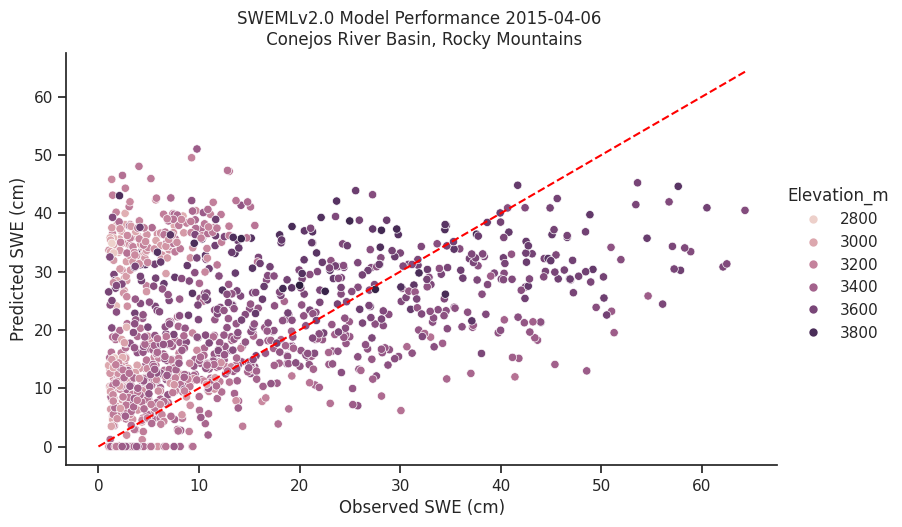

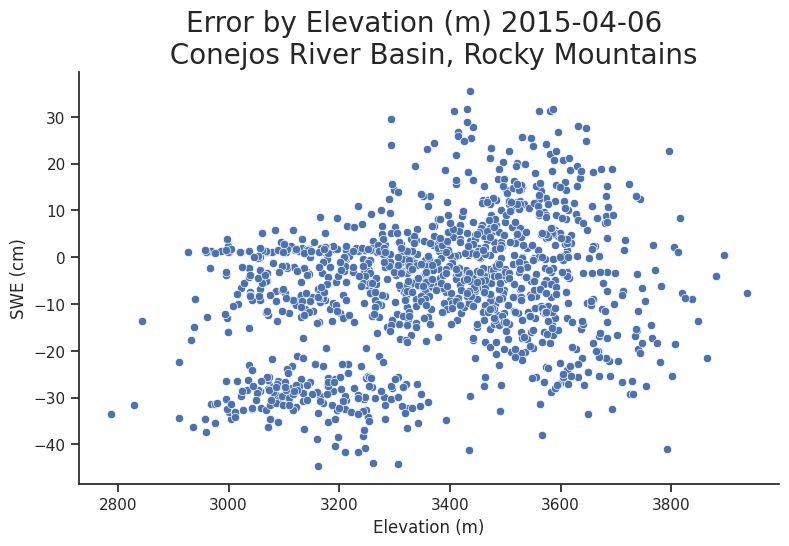

Error = observations - predictions


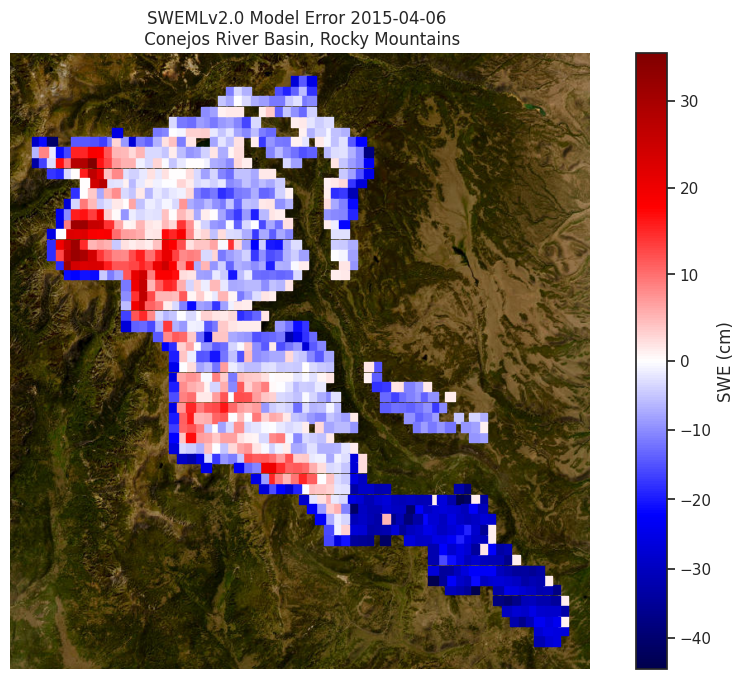

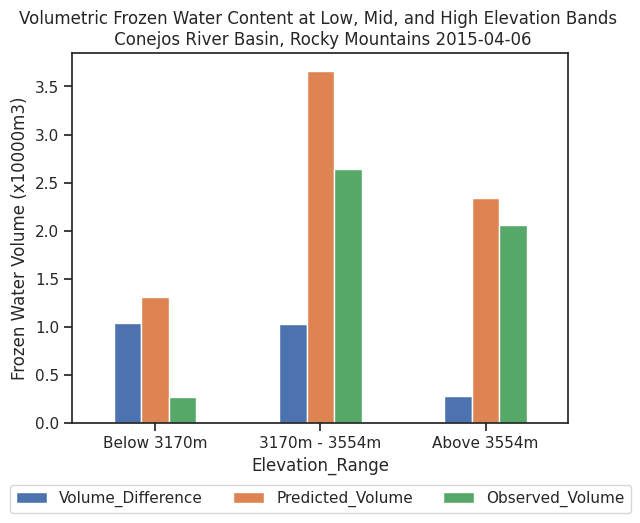

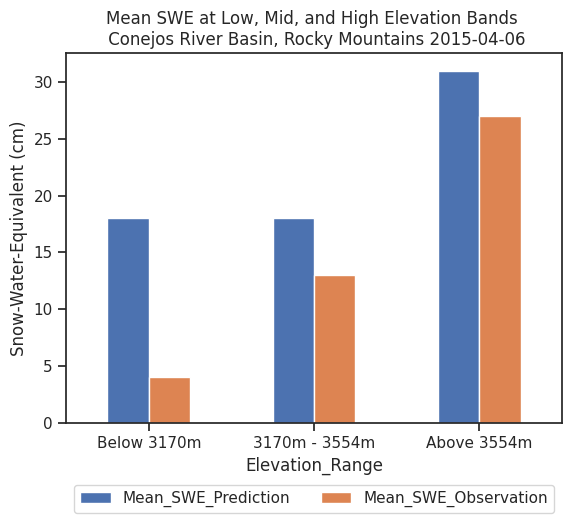

In [8]:
#Model run
# dates = [
#      #'2016-03-29', #Olympic
# #          '2015-04-06', #Conejos - only one obs, likely poor Never seen prediction location
# #          '2015-04-07', #upper Rio Grande
# #           '2018-03-30', #Taylor
# #          '2018-03-31', #East
# #          '2013-04-03', #Tuolumne
#  #           '2013-04-29', #Tuolumne
# #           '2015-04-12', #Kings
# #           '2019-03-25' #San Joaquin'
# #           '2019-03-29' #Merced
#         # '2019-03-24'
#          ]

Res =[#'500M_Resolution', 
      '750M_Resolution', 
      #'1000M_Resolution'
]

#alldata = False
#standard = True
# n_estimators = 3500
# maxDepth = 8
# eta = 0.1
savfig = False
for output_res in Res:
    for date in dates:


        DataFrame = 'Sturm_Seasonality_PrecipVIIRSGeoObsDFs'
        fSCA_thresh = '20_fSCA_Thresh'
        # date =  '2013-04-29'
        region = date_region[date]
        watershed = date_basin[date]
        markersize = 45


        #Prediction path
        Ppath = f"{HOME}/SWEMLv2.0/Predictions/{DataFrame}/{output_res}/{fSCA_thresh}"

        #Load data
        #EvalDF = pd.read_parquet(f"{Ppath}/All_Feats_HoldOut_03-29-2019.parquet")
        EvalDF = pd.read_parquet(f"{Ppath}/20SWEthresh_All_Feats_HoldOut_{date}.parquet")

        #Change obs/pred column names if necessary
        EvalDF.rename(columns={'ASO_swe_cm':'y_test','XGBoost_swe_cm':'y_pred'}, inplace=True)

        #just get swe >1cm
        EvalDF = EvalDF[EvalDF['y_test']>1]

        #Parity Plot
        Performance = SSWEET.parityplot(EvalDF, savfig, region, watershed, date)
        Performance

        #Error vs Elevation
        SSWEET.Model_Vs(EvalDF,'Elevation_m', 'Error', savfig, region, watershed, date)
        # SSWEET.Model_Vs(EvalDF,'Aspect_Deg', 'Error', savfig, region, watershed, date)
        # SSWEET.Model_Vs(EvalDF,'Slope_Deg', 'Error', savfig, region, watershed, date)
        # SSWEET.Model_Vs(EvalDF,'sturm_value', 'Error', savfig, region, watershed, date)
        # SSWEET.Model_Vs(EvalDF,'season_precip_cm', 'Error', savfig, region, watershed, date)


        #spatial
#         cmap = 'viridis' # use seismic for error, viridis or blues for preds/obs
#         var =  'y_pred' #'error'
#         var_short = 'Prediction'
#         Title = f'SWEMLv2.0 Model {var_short} {date} \n {watershed} River Basin, {region}'
#         variant = 'World_Imagery'
#         figname = f"./SWEMLv2.0/Evaluation/Figures/{region}_{watershed}_spatial_{var}_{date}_{output_res}"


#         SSWEET.SpatialAnalysis(EvalDF, markersize, cmap, var,Title, savfig, variant, figname)

        #spatial
        cmap = 'seismic' # use seismic for error, viridis or blues for preds/obs
        var =  'error' #'error'
        var_short = 'Error'
        Title = f'SWEMLv2.0 Model {var_short} {date} \n {watershed} River Basin, {region}'
        variant = 'World_Imagery'
        figname = f"./SWEMLv2.0/Evaluation/Figures/{region}_{watershed}_spatial_{var}_{date}_{output_res}"


        SSWEET.SpatialAnalysis(EvalDF, markersize, cmap, var,Title, savfig, variant, figname)

        #spatial
#         cmap = 'viridis' # use seismic for error, viridis or blues for preds/obs
#         var =  'y_test' #'error'
#         var_short = 'ASO Observations'
#         Title = f'{var_short} {date} \n {watershed} River Basin, {region}'
#         variant = 'World_Imagery'
#         figname = f"./SWEMLv2.0/Evaluation/Figures/{region}_{watershed}_spatial_{var}_{date}_{output_res}"


#         SSWEET.SpatialAnalysis(EvalDF, markersize, cmap, var,Title, savfig, variant, figname)

#         cmap = 'cool' # use seismic for error, viridis or blues for preds/obs
#         var =  'season_precip_cm' #'error'
#         var_short = 'Precipitation'
#         Title = f'{var_short} {date} \n {watershed} River Basin, {region}'
#         variant = 'World_Imagery'
#         figname = f"./SWEMLv2.0/Evaluation/Figures/{region}_{watershed}_spatial_{var}_{date}_{output_res}"


#         SSWEET.SpatialAnalysis(EvalDF, markersize, cmap, var,Title, savfig, variant, figname)

        cols =['Volume_Difference', 'Predicted_Volume', 'Observed_Volume']
        scaler = 10000
        ylab = f'Frozen Water Volume (x{scaler}m3)'
        ncol = 3
        Title = f'Volumetric Frozen Water Content at Low, Mid, and High Elevation Bands \n {watershed} River Basin, {region} {date}'
        figname = f"SWEMLv2.0/Evaluation/Figures/{region}_{watershed}_SWEVol_{date}_{output_res}.png"

        Vdf = SSWEET.barplot(EvalDF, cols, scaler, ylab, ncol, Title, savfig, figname)
        Vdf['watershed'] = watershed
        Vdf['Date'] = date

        cols =['Mean_SWE_Prediction', 'Mean_SWE_Observation']
        scaler = 1
        ylab = f'Snow-Water-Equivalent (cm)'
        ncol = 3
        Title = f'Mean SWE at Low, Mid, and High Elevation Bands \n {watershed} River Basin, {region} {date}'
        figname = f"SWEMLv2.0/Evaluation/Figures/{region}_{watershed}_MeanSWE_{date}_{output_res}.png"

        SWEdf = SSWEET.barplot(EvalDF, cols, scaler, ylab, ncol, Title, savfig, figname)
        SWEdf['watershed'] = watershed
        SWEdf['Date'] = date


        cols = ['RMSE', 'KGE', 'PBias']
        Performance = Performance[cols]
        Performance['watershed'] = watershed
        Performance['Date'] = date
        Performance['Resolution'] = output_res
        Performance['n_estimators'] = bestparams['n_estimators']
        Performance['max_depth'] = bestparams['max_depth']
        Performance['eta'] = bestparams['eta']
        Performance['alldata'] = alldata
        Performance['standard_training'] = standard
        
        PDF = pd.concat([PDF, Performance])
        VDF = pd.concat([VDF, Vdf])
        SWEDF = pd.concat([SWEDF, SWEdf])
        

In [9]:
PDF

,RMSE,KGE,PBias,watershed,Date,Resolution,n_estimators,max_depth,eta,alldata,standard_training
0,15.8,0.2,-47.62,Conejos,2015-04-06,750M_Resolution,1000,10,0.05,True,False
